In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
#sns.set_palette(palette='deep')
#sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
import numpy as np
from PIL import Image

In [ ]:
def mass_center(img,is_round=True):
    Y = img.mean(axis=1)
    X = img.mean(axis=0)
    Y_ = np.sum(np.arange(Y.shape[0]) * Y)/np.sum(Y)
    X_ = np.sum(np.arange(X.shape[0]) * X)/np.sum(X)
    if is_round:
        return int(round(X_)),int(round(Y_))
    return X_,Y_

def image_extract(img,newsize):
    x_s = np.where(img.mean(axis=0)!=0)[0].min()
    x_e = np.where(img.mean(axis=0)!=0)[0].max()
    
    y_s = np.where(img.mean(axis=1)!=0)[0].min()
    y_e = np.where(img.mean(axis=1)!=0)[0].max()
    
    x_c,_ = mass_center(img)
    x_s = x_c-newsize[1]//2
    x_e = x_c+newsize[1]//2
    img = img[y_s:y_e,x_s if x_s>0 else 0:x_e if x_e<img.shape[1] else img.shape[1]]
    return np.asarray(Image.fromarray(img).resize(size=newsize).convert('L'))

In [ ]:
temp = []

for id in range(1, 81):
  if id == 5:
    continue
  path = f'/content/drive/MyDrive/CASIA/{str(id).zfill(3)}/nm-01/090/'
  files = os.listdir(path)
  ''' files.sort()
  imgs = [imread(path+f) for f in files]
  imgs = [image_extract(i,(200,150)) for i in imgs]
  imgs = np.minimum(imgs,1)
  #print(type(images)) ---> numpy.ndarray
  print(imgs.shape)
  images = np.append(images, imgs, 0) '''
  temp.append(len(files))

print(min(temp), max(temp), temp)

43 76 [56, 61, 58, 68, 47, 56, 67, 53, 52, 66, 73, 67, 65, 63, 62, 56, 55, 54, 53, 63, 53, 68, 73, 60, 64, 71, 68, 58, 56, 60, 55, 59, 73, 61, 60, 71, 64, 68, 76, 51, 50, 62, 63, 72, 53, 64, 63, 54, 51, 50, 49, 54, 57, 61, 54, 51, 50, 62, 68, 56, 60, 54, 54, 62, 53, 61, 59, 58, 59, 67, 61, 63, 43, 64, 59, 64, 59, 62, 63]


In [ ]:
global input_time_step
global output_time_step
input_time_step=5
output_time_step=1

In [ ]:
def create_dataset(dataset, time_step=1, output_time_step=5):
  X_for, X_back, Y = [], [], []
  for i in range(time_step, len(dataset)-5):
    a = dataset[(i-time_step):i]
    b = dataset[(i+1):(i+6)][::-1]
    X_for.append(a)
    X_back.append(b)
    Y.append(dataset[i][:])
  return np.array(X_for), np.array(X_back), np.array(Y)

# Loading the models

In [ ]:
import tensorflow as tf

In [ ]:
encoder = tf.keras.models.load_model('/content/drive/MyDrive/enc_casia.h5')
decoder = tf.keras.models.load_model('/content/drive/MyDrive/dec_casia.h5')
lstm_for = tf.keras.models.load_model('/content/drive/MyDrive/lstm_for_casia.h5')
lstm_back = tf.keras.models.load_model('/content/drive/MyDrive/lstm_back_casia.h5')

# Data for training

In [ ]:
subjects = ['001', '036', '069', '072', '078']

In [ ]:
images = []

for id in subjects:
  path = f'/content/drive/MyDrive/CASIA/{id}/nm-01/090/'
  files = os.listdir(path)
  files.sort()
  imgs = [imread(path+f) for f in files]
  imgs = [image_extract(i,(200,150)) for i in imgs]
  imgs = np.minimum(imgs,1)
  #print(type(images)) ---> numpy.ndarray
  print(imgs.shape)
  images.append(imgs)

<ipython-input-11-5c161363674e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imgs = [imread(path+f) for f in files]


(56, 150, 200)
(60, 150, 200)
(58, 150, 200)
(61, 150, 200)
(59, 150, 200)


In [ ]:
enc_images = []

In [ ]:
for i in range(len(images)):
  enc_images.append(np.round(encoder.predict(np.expand_dims(images[i], axis=3))))

2/2 [==============================] - 0s 131ms/step


In [ ]:
input_shape = (input_time_step, 15200)

In [ ]:
X_for = []
X_back = []
Y = []

fusion_Y = []

for i in range(len(enc_images)):
  x_f, x_b, y = create_dataset(enc_images[i], input_time_step, output_time_step)
  X_for.extend(x_f.reshape(x_f.shape[0], 5, 15200))
  X_back.extend(x_b.reshape(x_b.shape[0], 5, 15200))
  Y.extend(y.reshape(y.shape[0], 15200))

  _, _, temp = create_dataset(images[i], input_time_step, output_time_step)
  fusion_Y.extend(temp)

In [ ]:
len(X_for)

244

In [ ]:
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Bidirectional, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
dim = 15200

In [ ]:
X_for = np.array(X_for)
X_back = np.array(X_back)
Y = np.array(Y)

In [ ]:
X_for.shape, X_back.shape

((244, 5, 15200), (244, 5, 15200))

In [ ]:
Y_for = lstm_for.predict(X_for)
Y_back = lstm_back.predict(X_back)

8/8 [==============================] - 1s 21ms/step


In [ ]:
Y_for.shape, Y_back.shape

((244, 15200), (244, 15200))

In [ ]:
Y_for = np.round(decoder.predict(Y_for.reshape((-1, 38, 50, 8))))
Y_back = np.round(decoder.predict(Y_back.reshape((-1, 38, 50, 8))))

Y_for.shape, Y_back.shape

8/8 [==============================] - 0s 5ms/step


((244, 150, 200, 1), (244, 150, 200, 1))

In [ ]:
len(fusion_Y), type(fusion_Y)

(244, list)

In [ ]:
fusion_Y = np.array(fusion_Y)

In [ ]:
shuffler = np.random.permutation(len(fusion_Y))

Y_for = Y_for[shuffler]
Y_back = Y_back[shuffler]
fusion_Y = fusion_Y[shuffler]

In [ ]:
Y_for.shape, Y_back.shape, fusion_Y.shape

((244, 150, 200, 1), (244, 150, 200, 1), (244, 150, 200))

In [ ]:
fusion_Y = np.expand_dims(fusion_Y, axis=3)

# Ground truth = `fusion_Y`
---
Produced by forward LSTM = `Y_for`
---
Produced by backward LStM = `Y_back`
---

# Fusion Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, Bidirectional, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Flatten, Reshape
from tensorflow.keras import layers

In [ ]:
inp = tf.keras.Input(shape=(150, 200, 2))

In [ ]:
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    if _project_shortcut or _strides != (1, 1):
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])

    return y

In [ ]:
d = residual_block(inp, 2)
print(d.shape)

(None, 150, 200, 2)


In [ ]:
d = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='merge_1')(d)
print(d.shape)

(None, 150, 200, 1)


In [ ]:
merge = tf.keras.Model(inp, d)

In [ ]:
merge.compile(optimizer='Adam', loss='binary_crossentropy')

In [ ]:
''' input = np.vstack((Y_for, Y_back))
input.shape '''
input = np.append(Y_for, Y_back, axis=3)
input.shape

(244, 150, 200, 2)

In [ ]:
np.max(Y_for), np.min(Y_back)

(1.0, 0.0)

In [ ]:
type(fusion_Y)

numpy.ndarray

In [ ]:
type(input)

numpy.ndarray

In [ ]:
fusion_Y.shape

(244, 150, 200, 1)

In [ ]:
merge_history = merge.fit(input, fusion_Y, epochs=200, validation_split=0.1)

Epoch 1/200
7/7 [==============================] - 2s 50ms/step - loss: 0.8619 - val_loss: 0.6335
Epoch 2/200
7/7 [==============================] - 0s 27ms/step - loss: 0.7973 - val_loss: 0.6262
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7575 - val_loss: 0.6177
Epoch 4/200
7/7 [==============================] - 0s 20ms/step - loss: 0.7233 - val_loss: 0.6088
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6939 - val_loss: 0.5999
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6680 - val_loss: 0.5911
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6442 - val_loss: 0.5815
Epoch 8/200
7/7 [==============================] - 0s 20ms/step - loss: 0.6209 - val_loss: 0.5709
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5960 - val_loss: 0.5594
Epoch 10/200
7/7 [==============================] - 0s 20ms/step - loss: 0.5684 - val_loss: 0.5459
Epoch 11/200
7/7 [=

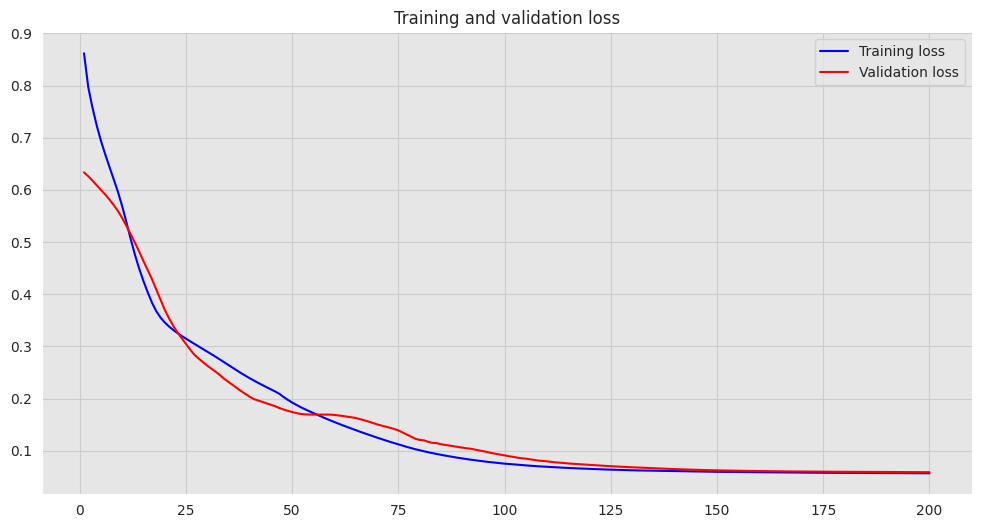

In [ ]:
loss = merge_history.history['loss']
val_loss = merge_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# NOW WE TEST FOR RECOGNITION

In [ ]:
images = None

In [ ]:
merge.save('/content/drive/MyDrive/merge_casia.h5')